<a href="https://colab.research.google.com/github/jennahgosciak/nyc_fire_risk/blob/main/00_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import contextily as ctx
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import seaborn.palettes
import seaborn.utils
import sys
from census import Census
from us import states
import http.client, urllib.request, urllib.parse, urllib.error, base64

root= r"C:/Users/Jennah/Desktop/Code/nyc_fire_risk"

# Estimating Fire Casualties in NYC
In NYC, recent fires--like the fire that occurred recently in the Bronx, in which 17 people died--have been devasting. It is important for cities to develop better tools for understanding where such catastrophic events might occur and target these areas for better prevention measures. Specifically, while a building may receive numerous violations from the New York City Housing and Preservation Department (HPD), HPD in turn may not know which buildings to target and when such violations are serious.

I propose a predictive model that calculates the risk of a __catastrophic__ fire using variables not considered in other models.

* I incorporate water and electricity use, as a measure of crowding in the building.
* I use data on past violations in the building, as a measure of a negligent landlord.
* Data on median household income in the surrounding area.
* Population density in the surrounding area.
* Average daily temperature.
* Number of residential building units and building FAR.

# Load data on fire dispatch events
## From January 1st, 2017 through the present
* Create a plot of fire events each year
* Only structural fires are included


In [2]:
url_fire_ev = 'https://data.cityofnewyork.us/resource/8m42-w767.csv?$limit=1000000&$where=incident_datetime>="2017-01-01"%20AND%20INCIDENT_CLASSIFICATION_GROUP="Structural%20Fires"'
fire_ev = pd.read_csv(url_fire_ev)
print(fire_ev.shape)

# if false, then we might not have downloaded all data
print(fire_ev.shape[0])
assert fire_ev.shape[0] < 1000000

(115079, 29)
115079


In [3]:
fire_ev["incident_date"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.date
fire_ev["incident_month"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.month
fire_ev["incident_day"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.day
fire_ev["incident_year"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.year

fire_ev["incident_md"]= fire_ev[["incident_month", "incident_day"]].astype(str).apply('-'.join, 1)

## More fire events occur in late November, December, and early January

<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\Jennah\AppData\Local\Temp/ipykernel_41220/1594349092.py:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  plt.xticks(np.arange(15, 365, round(365/12)), labels = [x for x in calendar.month_name if x is not ''])


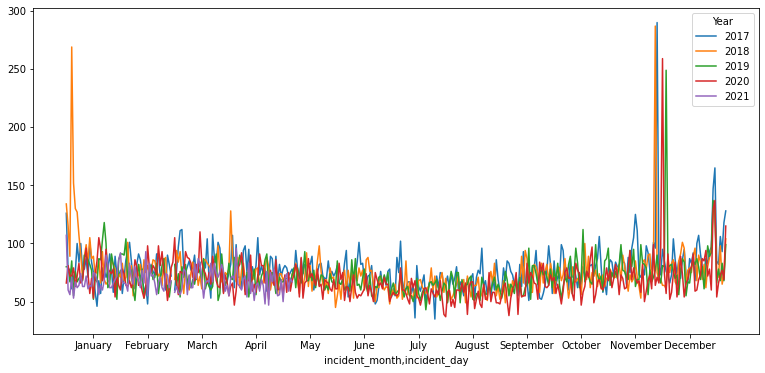

In [4]:
fire_ev_plt_df= fire_ev.groupby(["incident_year", "incident_month", "incident_day"]).size().unstack(level = 'incident_year')
fire_ev_plt_df.columns.name= "Year"

fig, ax = plt.subplots(figsize=(13, 6))
fire_ev_plt_df.plot(ax = ax)

x = [(x, 15) for x in list(range(1,13))]

plt.xticks(np.arange(15, 365, round(365/12)), labels = [x for x in calendar.month_name if x is not ''])
plt.savefig(os.join(root, "figs/fire_ev_line.pdf"))

# Load data on vacate orders from HPD, due to fire
## From January 1st, 2017 through the present

In [5]:
url_vac = 'https://data.cityofnewyork.us/resource/tb8q-a3ar.csv?$limit=1000000&$where=vacate_effective_date>="2017-01-01"%20AND%20primary_vacate_reason="Fire%20Damage"'
vac = pd.read_csv(url_vac)
print(vac.shape)

# if false, then we might not have downloaded all data
print(vac.shape[0])
assert vac.shape[0] < 1000000

(1523, 20)
1523


In [6]:
vac["vacate_effective_date2"]= pd.to_datetime(vac["vacate_effective_date"]).dt.date
vac["vacate_effective_month"]= pd.to_datetime(vac["vacate_effective_date"]).dt.month
vac["vacate_effective_day"]= pd.to_datetime(vac["vacate_effective_date"]).dt.day
vac["vacate_effective_year"]= pd.to_datetime(vac["vacate_effective_date"]).dt.year

vac["vacate_effective_md"]= vac[["vacate_effective_month", "vacate_effective_day"]].astype(str).apply('-'.join, 1)

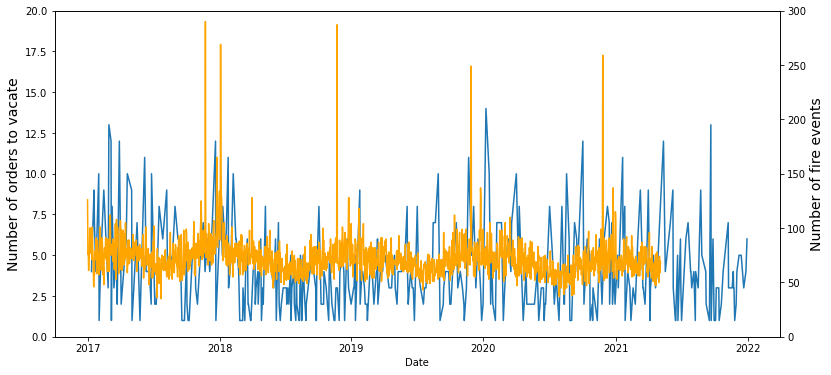

In [7]:
fig, ax = plt.subplots(figsize=(13, 6))
vac.loc[vac["vacate_effective_year"] < 2022, :].groupby("vacate_effective_date2").size().plot(ax = ax)
ax.set_ylabel("Number of orders to vacate", fontsize=14)
ax.set_ylim([0, 20])

# set second axis
ax2=ax.twinx()
fire_ev.groupby("incident_date").size().plot(ax = ax2, color = "orange")
ax2.set_ylabel("Number of fire events", fontsize=14)
ax2.set_ylim([0, 300])

ax.set_xlabel("Date")
plt.savefig(os.join(root, "figs/vac_line.pdf"))

In [8]:
## load pluto
pluto= gpd.read_file(os.join(root, "data/nyc_mappluto_21v4_shp/MapPLUTO.shp"))

In [9]:
vac_pluto= pluto.merge(vac, how = "inner", right_on = "bbl", left_on = "BBL")
vac_pluto

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,council_district,census_tract,bin,bbl,nta,vacate_effective_date2,vacate_effective_month,vacate_effective_day,vacate_effective_year,vacate_effective_md
0,MN,237,11,102,1004100,10041004001,41,4001,02,1,...,1,41,1077452.0,1.002370e+09,SoHo-TriBeCa-Civic Center-Little Italy,2018-02-28,2,28,2018,2-28
1,MN,239,11,102,1004100,10041002001,41,2001,02,1,...,1,41,1003119.0,1.002390e+09,SoHo-TriBeCa-Civic Center-Little Italy,2020-01-08,1,8,2020,1-8
2,MN,297,7501,103,1001600,10016005000,16,5000,02,1,...,1,16,1003827.0,1.002978e+09,Chinatown,2021-04-01,4,1,2021,4-1
3,MN,271,51,103,1000600,10006004001,6,4001,02,1,...,1,6,1003237.0,1.002710e+09,Lower East Side,2019-01-11,1,11,2019,1-11
4,MN,253,1,103,1000800,10008004000,8,4000,02,1,...,1,8,1077585.0,1.002530e+09,Chinatown ...,2017-11-17,11,17,2017,11-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,SI,2922,1,501,5004003,50040032000,40,2000,31,49,...,49,40,5106237.0,5.029220e+09,Grymes Hill-Clifton-Fox Hills,2020-10-14,10,14,2020,10-14
1512,SI,3585,7502,502,5011402,50114022004,114.02,2004,31,50,...,50,11402,5109580.0,5.035858e+09,New Dorp-Midland Beach ...,2017-05-18,5,18,2017,5-18
1513,SI,3983,45,503,5012806,50128063000,128.06,3000,31,50,...,50,12806,5105548.0,5.039830e+09,Oakwood-Oakwood Beach,2020-10-14,10,14,2020,10-14
1514,SI,3983,45,503,5012806,50128063000,128.06,3000,31,50,...,50,12806,5105548.0,5.039830e+09,Oakwood-Oakwood Beach,2017-06-26,6,26,2017,6-26


(905464.7390380852, 1075092.8783935553, 112492.5738036365, 280480.09001457837)

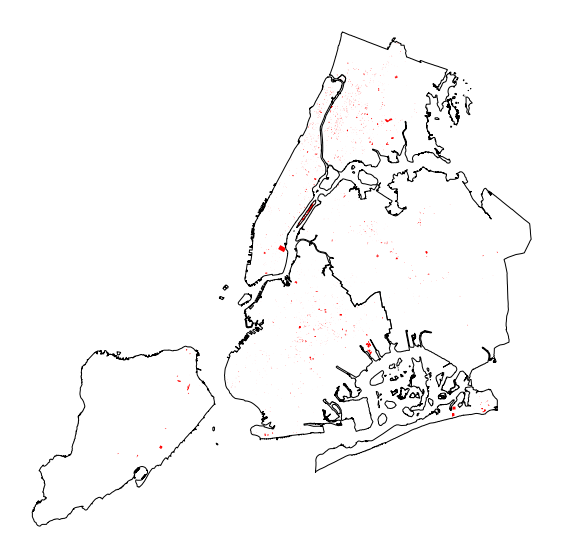

In [10]:
# load boros for background
boros= gpd.read_file('https://data.cityofnewyork.us/resource/7t3b-ywvw.geojson').set_crs(4326).to_crs(2263)
fig,ax = plt.subplots(figsize=(15,10))

vac_pluto.plot(ax = ax, facecolor = 'red')
boros.plot(ax = ax, facecolor = "none", edgecolor='black')
ax.axis('off')

(905464.7390380852, 1075092.8783935553, 112492.5738036365, 280480.09001457837)

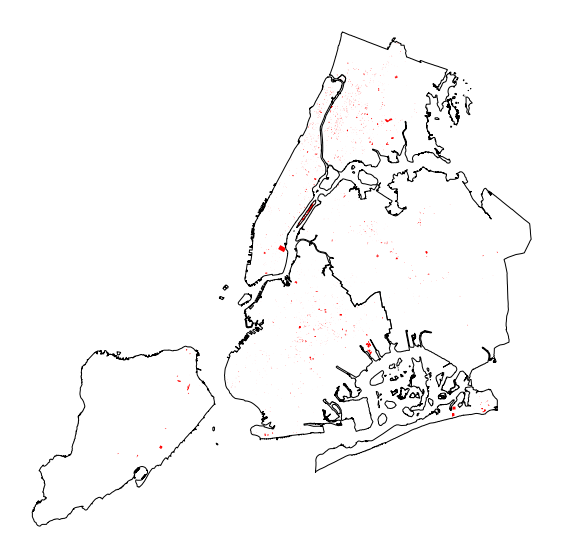

In [11]:
# convert to point data
#vac_pluto["geometry"]= vac_pluto["geometry"].representative_point()

fig,ax = plt.subplots(figsize=(15,10))
vac_pluto.plot(ax = ax, facecolor = 'red')
boros.plot(ax = ax, facecolor = "none", edgecolor='black')
ax.axis('off')

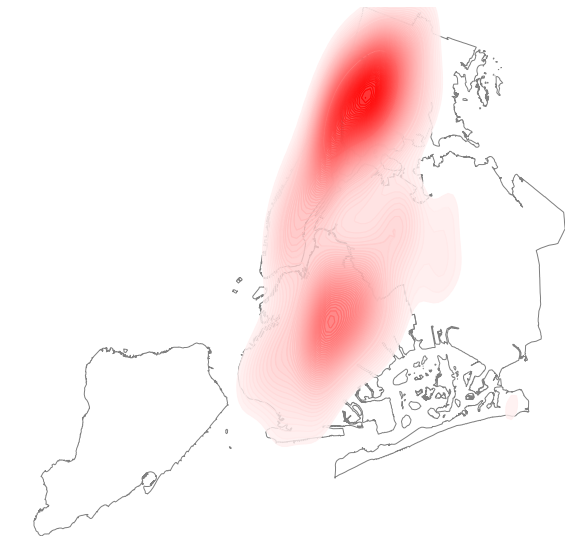

<Figure size 432x288 with 0 Axes>

In [12]:
# weight all the same
vac_pluto["weight"]= 1
# get extent
axis= boros.to_crs(4326).total_bounds
axis

# Calculate the KDE for heat map
data = np.c_[vac_pluto.longitude, vac_pluto.latitude]
kde = scipy.stats.gaussian_kde(data.T, bw_method="scott", weights=vac_pluto.weight)

# Compute std along axis
data_std = data.std(axis=0, ddof=1)
bw_x = getattr(kde, "scotts_factor")() * data_std[0]
bw_y = getattr(kde, "scotts_factor")() * data_std[1]
grid_x = grid_y = 100

x_support = seaborn.utils._kde_support(data[:, 0], bw_x, grid_x, 3, (axis[0], axis[2]))
y_support = seaborn.utils._kde_support(data[:, 1], bw_y, grid_y, 3, (axis[1], axis[3]))
xx, yy = np.meshgrid(x_support, y_support)
levels = kde([xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Create the map stretching over the requested area
ax = boros.to_crs(4326).plot(facecolor = 'none', edgecolor = 'gray',
                            figsize = (10, 10), alpha = 1)
cset = ax.contourf(xx, yy, levels,
    100,
    cmap=seaborn.palettes.blend_palette(('#ffffff10', '#ff0000af'), 100, as_cmap=True),
    antialiased=True,
    alpha = 0.8
)
# Hide lowest 4 levels
for i in range(0,5):
    cset.collections[i].set_alpha(0)
    
# remove lines on contour map
for c in cset.collections:
    c.set_edgecolor("face")
    
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.show()
plt.savefig(os.join(root, "figs/heatmap.pdf"), dpi=300, bbox_inches='tight')

## Load census data

In [13]:
c = Census("41d7a1f4bba48dd0b6f9e5a08cc66f9949d81523", year=2019)

dict= {}
for count in ['061', '085', '081', '047', '005']:
    temp= c.acs5.get(('NAME', 'B19013_001E'),
              {'for': 'tract:*', 'in': 'state:{} county:{}'.format(states.NY.fips, count)})
    dict.update({(i["county"] + i["tract"]):i["B19013_001E"] for i in temp})

In [14]:
# create med hh inc df
medhhinc= pd.DataFrame({"GEOID": dict.keys(),
                        "Median HH Inc": dict.values()})

# load tract data
tracts= gpd.read_file("https://data.cityofnewyork.us/resource/i69b-3rdj.geojson?$limit=100000")
# recode geoid var for merging
tracts["GEOID"]= np.where(
     tracts['boro_code'] == "5", 
    "085"+tracts["ct2010"], 
     np.where(
        tracts['boro_code'] == "1", 
    "061"+tracts["ct2010"],
         np.where(
        tracts['boro_code'] == "4", 
        "081"+tracts["ct2010"],
             np.where(
                tracts['boro_code'] == "3", 
            "047"+tracts["ct2010"],
                 np.where(
                    tracts['boro_code'] == "5", 
                "005"+tracts["ct2010"], '99999999'
                 )
             )
         )
     )
)
tracts["GEOID"].unique()

array(['085000900', '061009800', '061010200', ..., '085022300',
       '085020700', '085021300'], dtype=object)

In [15]:
# merge tracts to census data
tracts_census= tracts.merge(medhhinc, how = "inner", on = "GEOID")
tracts_census

tracts_census['Median HH Inc']= np.where(
     tracts_census['Median HH Inc'] < 0, np.nan,
    tracts_census['Median HH Inc'])

(-74.28337047811618, -73.67222994890716, 40.476988784652164, 40.89818324976431)

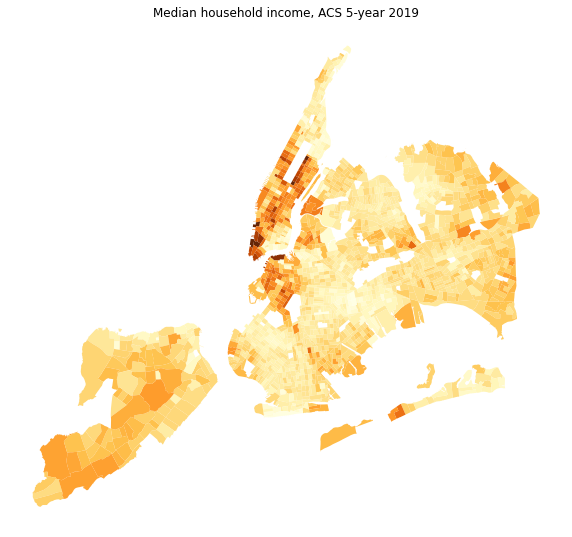

In [16]:
fig, ax= plt.subplots(figsize = (10, 10))
tracts_census.plot(column= "Median HH Inc", cmap = "YlOrBr", ax = ax)
plt.title("Median household income, ACS 5-year 2019")
ax.axis('off')

In [17]:
vac_pluto

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,census_tract,bin,bbl,nta,vacate_effective_date2,vacate_effective_month,vacate_effective_day,vacate_effective_year,vacate_effective_md,weight
0,MN,237,11,102,1004100,10041004001,41,4001,02,1,...,41,1077452.0,1.002370e+09,SoHo-TriBeCa-Civic Center-Little Italy,2018-02-28,2,28,2018,2-28,1
1,MN,239,11,102,1004100,10041002001,41,2001,02,1,...,41,1003119.0,1.002390e+09,SoHo-TriBeCa-Civic Center-Little Italy,2020-01-08,1,8,2020,1-8,1
2,MN,297,7501,103,1001600,10016005000,16,5000,02,1,...,16,1003827.0,1.002978e+09,Chinatown,2021-04-01,4,1,2021,4-1,1
3,MN,271,51,103,1000600,10006004001,6,4001,02,1,...,6,1003237.0,1.002710e+09,Lower East Side,2019-01-11,1,11,2019,1-11,1
4,MN,253,1,103,1000800,10008004000,8,4000,02,1,...,8,1077585.0,1.002530e+09,Chinatown ...,2017-11-17,11,17,2017,11-17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,SI,2922,1,501,5004003,50040032000,40,2000,31,49,...,40,5106237.0,5.029220e+09,Grymes Hill-Clifton-Fox Hills,2020-10-14,10,14,2020,10-14,1
1512,SI,3585,7502,502,5011402,50114022004,114.02,2004,31,50,...,11402,5109580.0,5.035858e+09,New Dorp-Midland Beach ...,2017-05-18,5,18,2017,5-18,1
1513,SI,3983,45,503,5012806,50128063000,128.06,3000,31,50,...,12806,5105548.0,5.039830e+09,Oakwood-Oakwood Beach,2020-10-14,10,14,2020,10-14,1
1514,SI,3983,45,503,5012806,50128063000,128.06,3000,31,50,...,12806,5105548.0,5.039830e+09,Oakwood-Oakwood Beach,2017-06-26,6,26,2017,6-26,1


## Load data on electricity and water usage
* [2020 data](https://data.cityofnewyork.us/resource/usc3-8zwd.csv)
* [2019 data](https://data.cityofnewyork.us/resource/wcm8-aq5w.csv)
* [2018 data](https://data.cityofnewyork.us/resource/4tys-3tzj.csv)
* [2017 data](https://data.cityofnewyork.us/resource/4t62-jm4m.csv)

In [31]:
url_2020= "https://data.cityofnewyork.us/resource/usc3-8zwd.csv?$limit=100000"
url_2019= "https://data.cityofnewyork.us/resource/wcm8-aq5w.csv?$limit=100000"
url_2018= "https://data.cityofnewyork.us/resource/4tys-3tzj.csv?$limit=100000"
url_2017= "https://data.cityofnewyork.us/resource/4t62-jm4m.csv?$limit=100000"

urls= [url_2017, url_2018, url_2019, url_2020]
cols= [["property_id", "year_ending",\
                                      "property_name", "nyc_borough_block_and_lot",\
                                      "occupancy", "year_built", "number_of_buildings",\
                                       "water_use_all_water_sources", "multifamily_housing_number",\
                                        "multifamily_housing_total"],\
      ["property_id", "year_ending",\
                                      "property_name", "nyc_borough_block_and_lot",\
                                      "occupancy", "year_built", "number_of_buildings",\
                                       "water_use_all_water_sources", "multifamily_housing_number",\
                                        "multifamily_housing_total"],\
      ["property_id", "year_ending",\
                                      "property_name", "nyc_borough_block_and_lot",\
                                      "occupancy", "year_built", "number_of_buildings",\
                                       "water_use_all_water_sources", "multifamily_housing_number",\
                                        "multifamily_housing_total"],\
      ["property_id", "year_ending",\
                                      "property_name", "nyc_borough_block_and_lot_bbl",\
                                      "occupancy", "year_built", "number_of_buildings",\
                                       "water_use_all_water_sources_kgal", "multifamily_housing_number_of_bedrooms",\
                                        "multifamily_housing_total_number_of_residential_living_units"]]
dfs= [pd.read_csv(urls[i], usecols = cols[i]) for i in range(0, 4)]
dfs

[       property_id              year_ending  \
 0          4593574  2017-12-31T00:00:00.000   
 1          6224375  2017-12-31T00:00:00.000   
 2          2967701  2017-12-31T00:00:00.000   
 3          4898531  2017-12-31T00:00:00.000   
 4          2917939  2017-12-31T00:00:00.000   
 ...            ...                      ...   
 34681      4047752  2017-12-31T00:00:00.000   
 34682      6682473  2017-12-31T00:00:00.000   
 34683      6682474  2017-12-31T00:00:00.000   
 34684      6682477  2017-12-31T00:00:00.000   
 34685      2819133  2017-12-31T00:00:00.000   
 
                                 property_name  nyc_borough_block_and_lot  \
 0                       The Argonaut Building                 1010287502   
 1                             Operative Cakes  2-00560-0062;2-05560-0062   
 2              Cathedral Preparatory Seminary               4-01872-0007   
 3                             The Nomad Hotel               1-00829-0050   
 4                      10 West 27 St

In [32]:
dfs[0].columns = cols[0]
dfs[1].columns = cols[0]
dfs[2].columns = cols[0]
dfs[3].columns = cols[0]

df_ew= pd.concat(dfs, axis = 0)
df_ew

,property_id,year_ending,property_name,nyc_borough_block_and_lot,occupancy,year_built,number_of_buildings,water_use_all_water_sources,multifamily_housing_number,multifamily_housing_total
0,4593574,2017-12-31T00:00:00.000,The Argonaut Building,1010287502,1909,1,95,NaN,NaN,3635.5
1,6224375,2017-12-31T00:00:00.000,Operative Cakes,2-00560-0062;2-05560-0062,1973,2,100,NaN,NaN,116.0
2,2967701,2017-12-31T00:00:00.000,Cathedral Preparatory Seminary,4-01872-0007,1963,1,100,NaN,NaN,102.9
3,4898531,2017-12-31T00:00:00.000,The Nomad Hotel,1-00829-0050,1999,1,85,NaN,NaN,10762.6
4,2917939,2017-12-31T00:00:00.000,10 West 27 Street Corp,1-00828-0053,1994,1,100,NaN,NaN,790.1
...,...,...,...,...,...,...,...,...,...,...
28062,17286197,ACF - 129th St Residence - 109 West 129th St: ...,2020-12-31T00:00:00.000,1-01914-0026,1920,1,100,Not Available,Not Available,Not Available
28063,17298485,110-31 Merrick Boulevard,2020-12-31T00:00:00.000,4102700059,1997,1,100,Not Available,Not Available,Not Available
28064,17298486,110-31A Merrick Boulevard,2020-12-31T00:00:00.000,4102700047,1997,1,100,Not Available,Not Available,Not Available
28065,17321529,402 EAST 78 STREET,2020-12-31T00:00:00.000,1014720046,1910,1,100,52,39,1788.6


In [33]:
df_ew.loc[:, "bbl"]= df_ew.iloc[:, 3].str.replace("[A-z]{1}[0-9]{3}-", "", regex = True)
df_ew.loc[:, "bbl"]= df_ew.loc[:, "bbl"].str.replace("-", "")
df_ew.loc[:, "bbl"]= df_ew["bbl"].str.replace(" ", ";")
df_ew.loc[:, "bbl"]= df_ew["bbl"].str.replace("(?<=[0-9]{10})/", ";", regex = True)
df_ew.loc[:, "bbl"]= df_ew["bbl"].str.replace("/", "")
df_ew.loc[:, "bbl"]= df_ew["bbl"].str.replace(",", ";")
df_ew.loc[:, "bbl"]= df_ew["bbl"].str.replace(":", ";")
df_ew.loc[:, "bbl"]= df_ew["bbl"].str.replace("and", ";")
df_ew.loc[:, "bbl"]= df_ew["bbl"].str.replace("&", ";")
df_ew.loc[:, "bbl"]= df_ew["bbl"].str.replace("NotAvailable", "")
df_ew.loc[:, "bbl"]= df_ew["bbl"].str.replace("multiple", "")
df_ew.loc[:, "bbl"]

0                   1010287502
1        2005600062;2055600062
2                   4018720007
3                   1008290050
4                   1008280053
                 ...          
28062               1019140026
28063               4102700059
28064               4102700047
28065               1014720046
28066               4102700057
Name: bbl, Length: 117082, dtype: object

In [34]:
df_ew.loc[:, ["bbl", "nyc_borough_block_and_lot"]]
df_ew[["bbl" + str(i) for i in range(0, 42)]]= df_ew["bbl"].str.split(pat= ";", n=-1, expand = True)
df_ew[["bbl" + str(i) for i in range(0, 42)]]

,bbl0,bbl1,bbl2,bbl3,bbl4,bbl5,bbl6,bbl7,bbl8,bbl9,...,bbl32,bbl33,bbl34,bbl35,bbl36,bbl37,bbl38,bbl39,bbl40,bbl41
0,1010287502,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2005600062,2055600062,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,4018720007,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,1008290050,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,1008280053,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28062,1019140026,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
28063,4102700059,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
28064,4102700047,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
28065,1014720046,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [35]:
cols = [x for x in df_ew.columns if x not in ["bbl" + str(i) for i in range(0, 42)] + ["bbl"]]
cols
df_ewlong= pd.melt(df_ew.drop("bbl", axis = 1), id_vars=cols,var_name='bbl_num', value_name='bbl')
print(df_ewlong[["bbl", "nyc_borough_block_and_lot"]].dropna().loc[(df_ewlong["bbl"].dropna()).map(len) > 10, :])

df_ewlong.loc[df_ewlong.loc[:, "bbl"] == "", "bbl"]= ""
df_ewlong= df_ewlong[(df_ewlong["bbl"].notna()) | (df_ewlong["bbl"].isna() & \
                                                         df_ewlong["bbl_num"] == "bbl0")].drop_duplicates()

                  bbl                          nyc_borough_block_and_lot
61      0004033410037                                    0004-03341-0037
319       1005800065.                                      1-00580-0065.
2061      10193100006                                      1-01931-00006
4018      1005800065.                                      1-00580-0065.
4290      20028110024                                        20028110024
...               ...                                                ...
482954    05006200200  05-00620-0001; 05-00620-0100; 05-00620-0200; 0...
516925    30605000019  3-06050-0051; 3-06050-0059; 3-06050-00019; 3-0...
541896    30605000019    3060500051; 3060500059; 30605000019; 3060500015
569611    30605000019    3060500051; 3060500059; 30605000019; 3060500015
717118    05006200300  05-00620-0001; 05-00620-0100; 05-00620-0200; 0...

[69 rows x 2 columns]


In [103]:
df_ewlong.loc[(df_ewlong["bbl"].map(len) != 10) | \
                (df_ewlong["bbl"] == "Code9Code9") | \
                (df_ewlong["bbl"] == "Not Available") | \
                (df_ewlong["bbl"] == "XXXXXXXXXX"), "bbl"] = ""
print(df_ewlong.loc[df_ewlong.index == 107, "bbl"])

df_ewlong["bbl"]= df_ewlong["bbl"].astype(float).astype(str).str.replace(".0", "", regex = False)

107    1012740011
Name: bbl, dtype: object


ValueError: could not convert string to float: ''

In [37]:
df_ewlong.loc[:, "bbl"]= pd.to_numeric(df_ewlong.loc[:, "bbl"])
vac_pluto_ew= pd.merge(vac_pluto, df_ewlong, how = "left", on = "bbl")

In [38]:
print(vac_pluto_ew.shape)
print(vac_pluto_ew.loc[vac_pluto_ew["property_id"].notna(), :].shape)
print(vac_pluto_ew.loc[vac_pluto_ew["property_id"].isna(), :].shape)
print(vac_pluto_ew.loc[(vac_pluto_ew["property_id"].isna()) & \
                       (vac_pluto_ew["BldgArea"] < 25000), "BldgArea"].shape)

(4279, 132)
(3563, 132)
(716, 132)
(694,)


In [72]:
df_ewlong.loc[(df_ewlong["multifamily_housing_total"] == "0") | \
              (df_ewlong["multifamily_housing_total"] == "Not Available"), "multifamily_housing_total"]= ""
df_ewlong["multifamily_housing_total"]= pd.to_numeric(df_ewlong["multifamily_housing_total"])

In [91]:
df_ewlong["water_num"]= pd.to_numeric(df_ewlong["water_use_all_water_sources"].str.replace("Not Available", ""))
df_ewlong["pwater_num"]= df_ewlong["water_num"].div(df_ewlong["multifamily_housing_total"].astype(float), \
                                                       fill_value = 0).fillna(0)

In [94]:
df_ewlong[["bbl","pwater_num", "water_num", "multifamily_housing_total"]].head()

,bbl,pwater_num,water_num,multifamily_housing_total
0,1.010288e+09,0.0,NaN,3635.5
1,2.005600e+09,0.0,NaN,116.0
2,4.018720e+09,0.0,NaN,102.9
3,1.008290e+09,0.0,NaN,10762.6
4,1.008280e+09,0.0,NaN,790.1


## Geocoding

In [104]:
import re
def req_geoclient(add):
    print(add)
    if type(add) != str:
        return ""
    zipcode= add[-5:]
    try:
        len(zipcode) == 5
    except AttributeError:
        print(add)
        
    assert add[-6] == " "
    
    try:
        boro = re.search("(Manhattan|Brooklyn|Bronx|Staten Island|Queens)", add).group(1)
    except AttributeError:
        print("Borough incorrect: {}".format(add))
        return ""
    
    try:
        houseNumber = re.search("[0-9]+-*[0-9]*(?=\\s)", add).group(0)
    except AttributeError:
        print("House number incorrect: {}".format(add))
        return ""
    
    try:
        street = re.search("(?<=[0-9]\\s).+(?=\\s+(Manhattan|Brooklyn|Bronx|Staten Island|Queens))", add).group(0)
    except AttributeError:
        print("Street incorrect")
        return ""
    
    headers = {
        # Request headers
        'Ocp-Apim-Subscription-Key': '8023630502244bbbb65e9090d28c2615',
    }

    params = urllib.parse.urlencode({"houseNumber":houseNumber,
                                     "street": street,
                                     "borough": boro,
                                     "zip": zipcode})

    try:
        conn = http.client.HTTPSConnection('api.nyc.gov')
        conn.request("GET", "/geo/geoclient/v1/address.json?%s" % params, "{body}", headers)
        response = conn.getresponse()
        data = response.read()
        conn.close()
        
        df= pd.read_json(data).transpose()
        return df.loc[:,"bbl"]
    except Exception as e:
        print("Incorrect address: {0}; {1}".format(add, street))
        return ""
    
req_geoclient("4416 6th Avenue Brooklyn, 11220")

4416 6th Avenue Brooklyn, 11220


address    3007390043
Name: bbl, dtype: object

In [107]:
df_filt= df_ewlong[df_ewlong["bbl"].map(len) != 10].copy()
print(df_filt.shape)

df_filt.loc[df_filt.loc[:, "borough"] == "STATEN IS", "borough"]= "Staten Island"
df_filt.loc[:, "address_form"]= df_filt.loc[:, "address_1"] + " " + df_filt.loc[:, "borough"].str.title() + \
                                    ", " + df_filt["postcode"].apply(str).str.strip()
df_filt["address_form"].apply(req_geoclient)

(1842, 14)


KeyError: 'borough'

In [ ]:
print(df_filt.shape)